In [93]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [104]:
import datetime
import os
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from notebook_shared import utils
from notebook_shared import violinplotutil

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import Series

import seaborn as sns
sns.set()
matplotlib.style.use('seaborn-colorblind')

INPUT_FILE = "dataset"
FSIZE = "full"

df = pd.read_parquet(utils.get_dataset_path(INPUT_FILE, FSIZE))
sns.set(font_scale=1.2)
CM = 1/2.54  # centimeters to inches conversion

In [95]:
df[['driver_invocation', 'workload_invocation', 'provider', 'region', '1_run_id']]

,driver_invocation,workload_invocation,provider,region,1_run_id
0,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,28
1,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,69
2,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,74
3,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,86
4,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,103
...,...,...,...,...,...
499531,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,19
499532,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,35
499533,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,83
499534,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,90


In [96]:
df.columns

Index(['driver_invocation', 'workload_invocation', 'provider', 'region',
       'dirty_measurement', 'folder_uuid', '1_run_id', '2_thread_id',
       'SAAFMemoryDeltaError', 'SAAFMemoryError', 'contextSwitches',
       'contextSwitchesDelta', 'cpuIdle', 'cpuIdleDelta', 'cpuIowait',
       'cpuIowaitDelta', 'cpuIrqDelta', 'cpuKrn', 'cpuKrnDelta', 'cpuModel',
       'cpuNice', 'cpuSoftIrq', 'cpuSoftIrqDelta', 'cpuType', 'cpuUsr',
       'cpuUsrDelta', 'endTime', 'frameworkRuntime', 'frameworkRuntimeDeltas',
       'freeMemory', 'functionName', 'latency', 'linuxVersion', 'newcontainer',
       'roundTripTime', 'runtime', 'runtimeOverlap', 'startTime',
       'totalMemory', 'userRuntime', 'uuid', 'vmcpusteal', 'vmcpustealDelta',
       'vmuptime', 'containerID', 'functionMemory', 'pageFaults',
       'pageFaultsDelta', 'vmID', 'dow_utc', 'tod_utc', 'timezone',
       'measure group', 'local_dow', 'local_tod'],
      dtype='object')

In [97]:
provider_region_mg_df = df.groupby( ['provider', 'region', 'measure group'], observed=True).count().reset_index()
provider_region_mg_df = provider_region_mg_df.sort_values(by=['measure group', 'provider','region'])

for index, row in provider_region_mg_df.iterrows():
    region = row['region']
    fill = ' '
    align = '<'
    width = 30
    val = f'"{region}":'
    print(f'{val:{fill}{align}{width}} "",')

"ap-southeast-2":              "",
"australiaeast":               "",
"australia-southeast1":        "",
"ca-central-1":                "",
"northamerica-northeast1":     "",
"us-east-1":                   "",
"eastus":                      "",
"us-east4":                    "",
"eu-central-1":                "",
"germanywestcentral":          "",
"europe-west3":                "",
"ap-south-1":                  "",
"centralindia":                "",
"asia-south1":                 "",
"ap-northeast-1":              "",
"japaneast":                   "",
"asia-northeast1":             "",
"sa-east-1":                   "",
"brazilsouth":                 "",
"southamerica-east1":          "",
"eu-west-2":                   "",
"uksouth":                     "",
"europe-west2":                "",
"us-west-1":                   "",
"us-west-2":                   "",
"westus":                      "",
"westus2":                     "",
"us-west2":                    "",
"us-west4":         

In [98]:
region_id_mapping = {
    "ap-southeast-2":              "aws-au",
    "australiaeast":               "azr-au",
    "australia-southeast1":        "gcp-au",
    "ca-central-1":                "aws-ca",
    "northamerica-northeast1":     "gcp-ca",
    "us-east-1":                   "aws-us-e",
    "eastus":                      "azr-us-e",
    "us-east4":                    "gcp-us-e",
    "eu-central-1":                "aws-de",
    "germanywestcentral":          "azr-de",
    "europe-west3":                "gcp-de",
    "ap-south-1":                  "aws-in",
    "centralindia":                "azr-in",
    "asia-south1":                 "gcp-in",
    "ap-northeast-1":              "aws-jp",
    "japaneast":                   "azr-jp",
    "asia-northeast1":             "gcp-jp",
    "sa-east-1":                   "aws-br",
    "brazilsouth":                 "azr-br",
    "southamerica-east1":          "gcp-br",
    "eu-west-2":                   "aws-uk",
    "uksouth":                     "azr-uk",
    "europe-west2":                "gcp-uk",
    "us-west-1":                   "aws-us-w1",
    "us-west-2":                   "aws-us-w2",
    "westus":                      "azr-us-w1",
    "westus2":                     "azr-us-w2",
    "us-west2":                    "gcp-us-w1",
    "us-west4":                    "gcp-us-w2",
}

In [99]:
df

,driver_invocation,workload_invocation,provider,region,dirty_measurement,folder_uuid,1_run_id,2_thread_id,SAAFMemoryDeltaError,SAAFMemoryError,...,functionMemory,pageFaults,pageFaultsDelta,vmID,dow_utc,tod_utc,timezone,measure group,local_dow,local_tod
0,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,True,81285f3e-341e-11ec-be3c-8bf2eba3159e,28,1,NaN,NaN,...,1024,244616,3854,ZGosOo,Sunday,1330,Asia/Tokyo,Japan,Sunday,2230
1,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,True,81285f3e-341e-11ec-be3c-8bf2eba3159e,69,3,NaN,NaN,...,1024,452552,3867,wsJB4t,Sunday,1330,Asia/Tokyo,Japan,Sunday,2230
2,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,True,81285f3e-341e-11ec-be3c-8bf2eba3159e,74,0,NaN,NaN,...,1024,473831,3862,ZGosOo,Sunday,1330,Asia/Tokyo,Japan,Sunday,2230
3,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,True,81285f3e-341e-11ec-be3c-8bf2eba3159e,86,0,NaN,NaN,...,1024,521799,3812,dYpWzo,Sunday,1330,Asia/Tokyo,Japan,Sunday,2230
4,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,True,81285f3e-341e-11ec-be3c-8bf2eba3159e,103,3,NaN,NaN,...,1024,641053,3832,ZGosOo,Sunday,1330,Asia/Tokyo,Japan,Sunday,2230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499531,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,True,c0093932-341b-11ec-be3c-8bf2eba3159e,19,3,/proc/vmstat does not exist!,/proc/vmstat does not exist!,...,<NA>,<NA>,<NA>,<NA>,Thursday,2330,America/Los_Angeles,West US,Thursday,1630
499532,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,True,c0093932-341b-11ec-be3c-8bf2eba3159e,35,0,/proc/vmstat does not exist!,/proc/vmstat does not exist!,...,<NA>,<NA>,<NA>,<NA>,Thursday,2330,America/Los_Angeles,West US,Thursday,1630
499533,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,True,c0093932-341b-11ec-be3c-8bf2eba3159e,83,2,/proc/vmstat does not exist!,/proc/vmstat does not exist!,...,<NA>,<NA>,<NA>,<NA>,Thursday,2330,America/Los_Angeles,West US,Thursday,1630
499534,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,True,c0093932-341b-11ec-be3c-8bf2eba3159e,90,1,/proc/vmstat does not exist!,/proc/vmstat does not exist!,...,<NA>,<NA>,<NA>,<NA>,Thursday,2330,America/Los_Angeles,West US,Thursday,1630


In [100]:
# df = df.assign(region=df['region'].map(region_id_mapping))

In [101]:
# Common Stuff
provider_region_mapping = {}
provider_region_mg_df = df.groupby( ['provider', 'region'], observed=True)['measure group'].unique().reset_index()
provider_region_mg_df
for index, row in provider_region_mg_df.iterrows():
    for measure_group in row['measure group']:
        region = row['region']
        provider = row['provider']
        measure_group = row['measure group'][0]
        # exception handling:
        plot_region = region
        if region == 'northamerica-northeast1':
            plot_region = 'northamerica\n-northeast1'
        if region == 'southamerica-east1':
            plot_region = 'southamerica-\neast1'
        if region == 'australia-southeast1':
            plot_region = 'australia\n-southeast1'
        
        provider_region_mapping[f"({provider}, {region})"] = {
            'region': region,
            'plot region': plot_region,
            'measure group': measure_group,
            'provider': provider
        }
        provider_region_mapping[f"({provider}, {region}, {measure_group})"] = {
            'region': region,
            'plot region': plot_region,
            'measure group': measure_group,
            'provider': provider
        }

# Mean Runtime and CV Per Provider
- Q: Has a provider a overall characterstics or do specific regions stand out?
- Q: Does have one provider an overall more volatile region?

In [102]:
cov_df = df.groupby( ['provider', 'region'], observed=True)['runtime'].apply(utils.cov)
cov_df = pd.DataFrame(cov_df).sort_values(by='region')

AWS


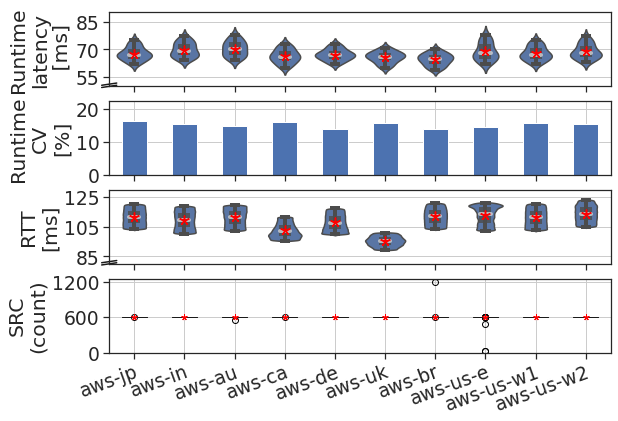

runtimebx 
                           runtime                                         \
                            count       mean       std   min   25%   50%   
provider region                                                            
AWS      ap-northeast-1  926387.0  67.779340  3.507182  62.0  65.0  67.0   
         ap-south-1      871720.0  69.873786  3.818698  64.0  67.0  69.0   
         ap-southeast-2  945986.0  70.484830  4.022142  64.0  67.0  70.0   
         ca-central-1    923543.0  66.469524  3.631024  60.0  64.0  66.0   
         eu-central-1    904657.0  67.237836  2.954712  62.0  65.0  67.0   
         eu-west-2       926541.0  65.859413  2.972326  60.0  64.0  66.0   
         sa-east-1       914609.0  64.603310  3.100743  59.0  62.0  65.0   
         us-east-1       933410.0  68.948700  4.664786  62.0  65.0  68.0   
         us-west-1       901966.0  67.936187  3.653996  62.0  65.0  67.0   
         us-west-2       943479.0  69.012228  3.867792  63.0  66.0  68.0   


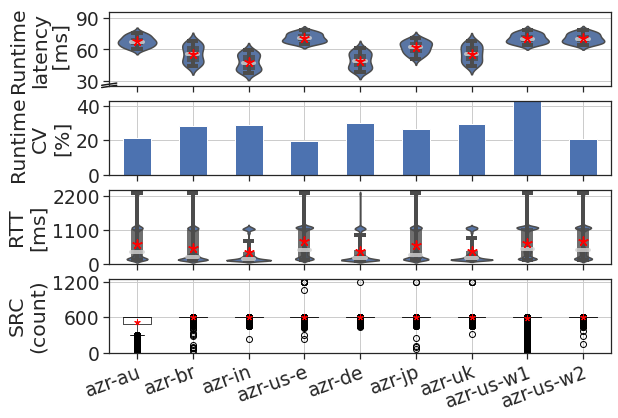

runtimebx 
                               runtime                                         \
                                count       mean       std   min   25%   50%   
provider region                                                                
AZURE    australiaeast       791029.0  67.717206  4.673027  60.0  64.0  67.0   
         brazilsouth         890645.0  55.839857  7.842681  44.0  48.0  56.0   
         centralindia        879161.0  47.853478  7.073692  38.0  41.0  47.0   
         eastus              924545.0  71.017867  4.001760  65.0  68.0  71.0   
         germanywestcentral  900423.0  49.398828  7.127824  39.0  43.0  49.0   
         japaneast           890760.0  61.960560  5.607318  51.0  57.0  62.0   
         uksouth             895755.0  55.959593  7.537987  44.0  49.0  56.0   
         westus              914007.0  70.459758  4.238704  64.0  67.0  70.0   
         westus2             914071.0  70.531010  4.231152  64.0  67.0  70.0   

                           

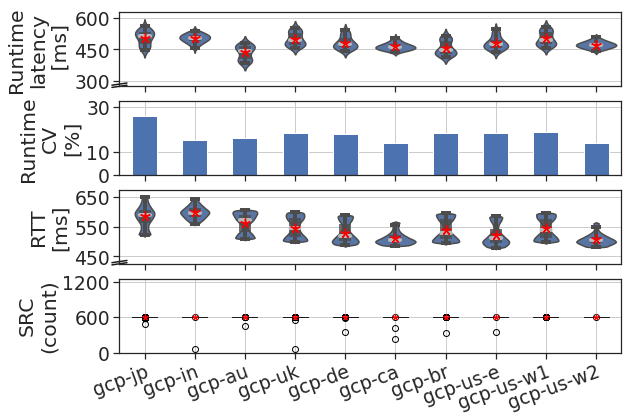

runtimebx 
                                    runtime                                \
                                     count        mean        std    min   
provider region                                                            
GCP      asia-northeast1          883224.0  505.174002  32.888018  445.0   
         asia-south1              872872.0  502.361271  19.932936  454.0   
         australia-southeast1     881507.0  435.199654  32.192091  383.0   
         europe-west2             872649.0  499.592205  30.354491  457.0   
         europe-west3             877572.0  481.894707  28.461980  441.0   
         northamerica-northeast1  872616.0  464.305939  16.154973  438.0   
         southamerica-east1       888317.0  457.155115  32.298694  415.0   
         us-east4                 875937.0  479.939366  28.431815  437.0   
         us-west2                 887440.0  501.672008  31.369217  458.0   
         us-west4                 872538.0  471.936208  15.038465  443.0   


In [105]:
factor=2
sns.set(font_scale=1.7)
sns.set_style("ticks",{'axes.grid' : True})

for provider in df['provider'].unique():
    SHAREX = True
    fig, axes = plt.subplots(figsize=(8.85*CM*factor, 6*CM*factor), nrows=4, frameon=False, sharex=SHAREX)
    
    # Runtime
    pdf = df[['provider', 'region', 'runtime']][df['provider'] == provider]
    pdf = utils.remove_outliers_group_quantiles(pdf, 'region', 'runtime')
    
    
    pdf['runtime'] = pdf['runtime'].astype(np.float64)
    pdf['region'] = pdf['region'].cat.remove_unused_categories()
        
    violinplotutil.violinplot(x='region', y='runtime', ax=axes[0], data=pdf, bw=0.5)
    
    runtime_yticks = {
        "AWS": [55, 70, 85],
        "AZURE": [30, 60, 90],
        "GCP": [300, 450, 600],
    }
    
    runtime_ylims = {
        "AWS": [50, 90],
        "AZURE": [25, 95],
        "GCP": [275, 625],
    }
    
    axes[0].set_yticks(runtime_yticks[provider])
    axes[0].set_ylim(bottom=runtime_ylims[provider][0], top=runtime_ylims[provider][1])    
    
    if (runtime_yticks[provider][0] != 0):
        ax = axes[0]
        d = .015  # how big to make the diagonal lines in axes coordinates
        shift = 0.03

        # arguments to pass to plot, just so we don't keep repeating them
        kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
        # bottom-left diagonal
        ax.plot((-d, +d), (-d, +d), **kwargs)
        # bottom-left diagonal
        ax.plot((-d, +d), (-d+shift, +d+shift), **kwargs) 
    
    axes[0].set_ylabel('Runtime\nlatency\n [ms]')
    
    pdf = pdf.sort_values(by=['provider', 'region'])
    bxdf = pdf.groupby(['provider','region'], observed=True)
    
    
    # Runtime COV
    cov_provider = cov_df.loc[provider]
    cov_provider = cov_provider * 100
    cov_provider = pd.DataFrame(cov_provider).sort_values(['region'])
    cov_provider.plot(kind='bar', ax=axes[1], sharex=SHAREX)
    
    axes[1].get_legend().remove()
    axes[1].set_ylabel('Runtime\nCV\n[%]')
    
    cov_yticks = {
        "AWS": [0, 10, 20],
        "AZURE": [0, 20, 40],
        "GCP": [0, 10, 30],
    }
    
    cov_ylims = {
        "AWS": [0, 22.5],
        "AZURE": [0, 42.5],
        "GCP": [0, 32.5],
    }
    
    axes[1].set_yticks(cov_yticks[provider])
    axes[1].set_ylim(bottom=cov_ylims[provider][0], top=cov_ylims[provider][1])    
    
    # Round Trip Time
    if (provider == "AWS"):
        pdf = df[['provider', 'region', 'roundTripTime']][df['provider'] == provider]
        
        
        # pdf = utils.remove_outliers_group(pdf, 'region', 'roundTripTime')
        pdf = utils.remove_outliers_group_quantiles(pdf, 'region', 'roundTripTime')
        
        # todo check if ok
        pdf['roundTripTime'] = pdf['roundTripTime'].astype(np.float64)
        pdf['region'] = pdf['region'].cat.remove_unused_categories()
        
        violinplotutil.violinplot(x='region', y='roundTripTime', ax=axes[2], data=pdf)
        
        rtt_df = pdf.groupby(['region'], observed=True)
        # utils.boxplot(axes[2], rtt_df, 'Round Trip Time', lambda x: x, rot=90, sharex=SHAREX, showfliers=True)
    else:
        pdf = df[['provider', 'region', 'roundTripTime']][df['provider'] == provider]
        pdf = utils.remove_outliers_group_quantiles(pdf, 'region', 'roundTripTime')
        
        # todo check if ok
        pdf['roundTripTime'] = pdf['roundTripTime'].astype(np.float64)
        pdf['region'] = pdf['region'].cat.remove_unused_categories()
        
        violinplotutil.violinplot(x='region', y='roundTripTime', ax=axes[2], data=pdf)
        
        rtt_df = pdf.groupby(['region'], observed=True)
    
    axes[2].set_ylabel('RTT\n[ms]')
    
    rtt_yticks = {
        "AWS": [85, 105, 125],
        "AZURE": [0, 1100, 2200],
        "GCP": [450, 550, 650],
    }
    
    rtt_ylims = {
        "AWS": [80, 130],
        "AZURE": [0, 2400],
        "GCP": [425, 675],
    }
    
    axes[2].set_yticks(rtt_yticks[provider])
    axes[2].set_ylim(bottom=rtt_ylims[provider][0], top=rtt_ylims[provider][1])
    if (rtt_yticks[provider][0] != 0):
        ax = axes[2]
        d = .015  # how big to make the diagonal lines in axes coordinates
        shift = 0.03

        # arguments to pass to plot, just so we don't keep repeating them
        kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
        # bottom-left diagonal
        ax.plot((-d, +d), (-d, +d), **kwargs)
        # bottom-left diagonal
        ax.plot((-d, +d), (-d+shift, +d+shift), **kwargs) 
    
    # resp df
    resp_df = df[df['provider'] == provider].groupby( ['provider', 'region', 'driver_invocation'], observed=True).size().reset_index(name='counts')
    df_resp_boxplot = resp_df[['provider', 'region', 'counts']].sort_values(by=['region']).groupby(['provider', 'region'], observed=True)
    ax = utils.boxplot(axes[3], df_resp_boxplot, 'SRC\n(count)', lambda x: x, rot=0, sharex=False, showfliers=True, with_mean=True)
    
    resp_yticks = {
        "AWS": [0, 600, 1200],
        "AZURE": [0, 600, 1200],
        "GCP": [0, 600, 1200],
    }
    
    resp_ylims = {
        "AWS": [0, 1250],
        "AZURE": [0, 1250],
        "GCP": [0, 1250],
    }
    
    ax.set_yticks(resp_yticks[provider])
    ax.set_ylim(bottom=resp_ylims[provider][0], top=resp_ylims[provider][1])
    
    # Set Region Names
    region_name_ax = ax
    labels = []
    i = 0
    for tick in region_name_ax.get_xticklabels():
        region = tick.get_text().split(',')[1].strip()
        key = f"({provider}, {region})"
        mapping = provider_region_mapping[key]
        region = mapping['region']
        measure_group = mapping['measure group']
        label = region_id_mapping[region]
        # i+=1
        if (i % 2 == 1):
            labels.append(f"\n{label}")
        # labels.append(f"{region}\n({measure_group})")
        else: 
            labels.append(f"{label}")
    
    # region_name_ax.set_xticklabels(labels) #, rotation=0, ha="right", rotation_mode="anchor")
    region_name_ax.set_xticklabels(labels, rotation=20, ha="right", rotation_mode="anchor")
    region_name_ax.set_xlabel('')

    fig.tight_layout(pad=0)
    print(provider)
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.2)
    # plt.margins(x=0,y=0)
    utils.plot( ['region_analysis', f'overview_{provider}'], runtimebx=bxdf.describe(), rttbx=rtt_df.describe(), respbx=df_resp_boxplot.describe(), cov=cov_provider)

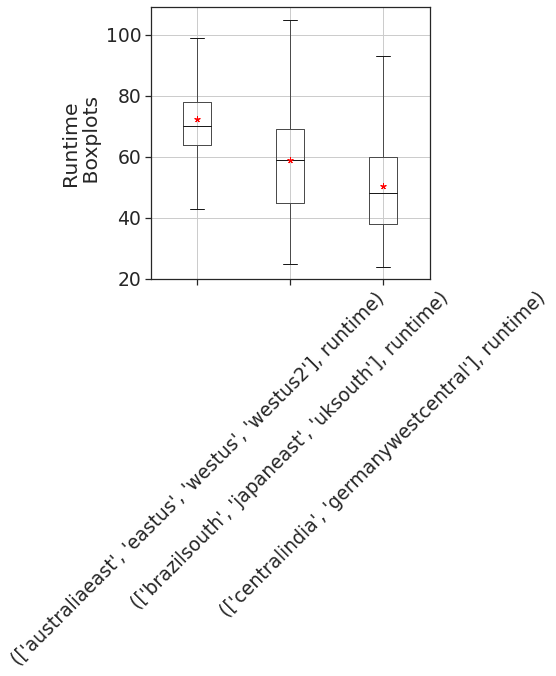

In [11]:
# Get MF finding numners for Azure Groups:
# % TODO: Calculate average runtimes for the different groups:
group_1 = ['australiaeast', 'eastus', 'westus', 'westus2']
group_2 = ['brazilsouth', 'japaneast', 'uksouth']
group_3 = ['centralindia', 'germanywestcentral']

df_grouped_runtime = df[df['region'].isin(group_1 + group_2 + group_3)][['provider', 'region', 'runtime']]
df_grouped_runtime['group'] = 'none'
df_grouped_runtime.loc[df_grouped_runtime['region'].isin(group_1), 'group'] = str(group_1)
df_grouped_runtime.loc[df_grouped_runtime['region'].isin(group_2), 'group'] = str(group_2)
df_grouped_runtime.loc[df_grouped_runtime['region'].isin(group_3), 'group'] = str(group_3)

df_grouped_runtime_result = df_grouped_runtime.groupby('group')

# CV Boxplots
fig, axes = plt.subplots(figsize=(5,5))
utils.boxplot(axes, df_grouped_runtime_result, "Runtime\n Boxplots", lambda x: x, with_mean=True,rot=45)
utils.savefig(fig, ['region_analysis', f'azure_grouped_runtime'], data=df_grouped_runtime_result.describe())

## Runtime Distribution Across All Providers

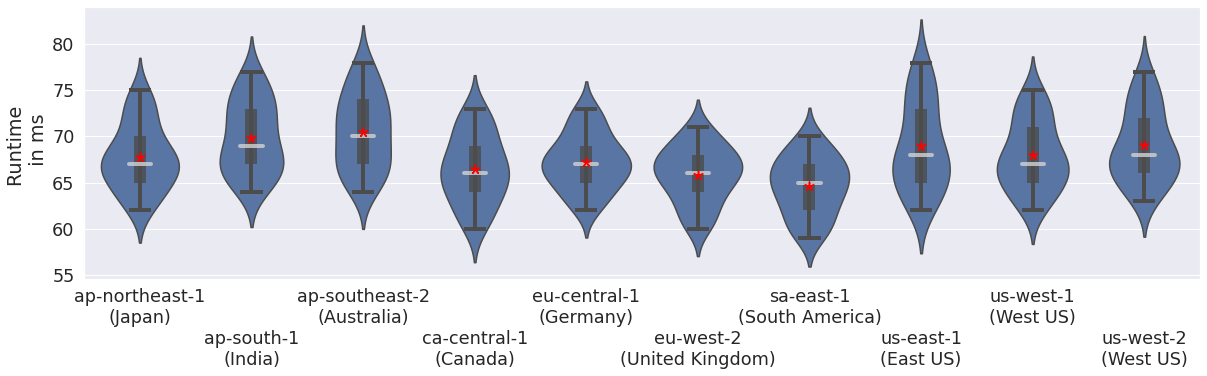

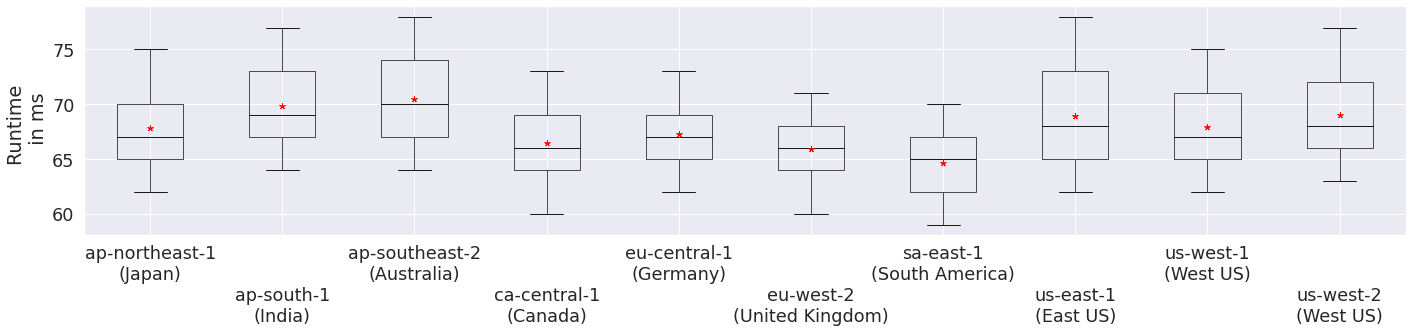

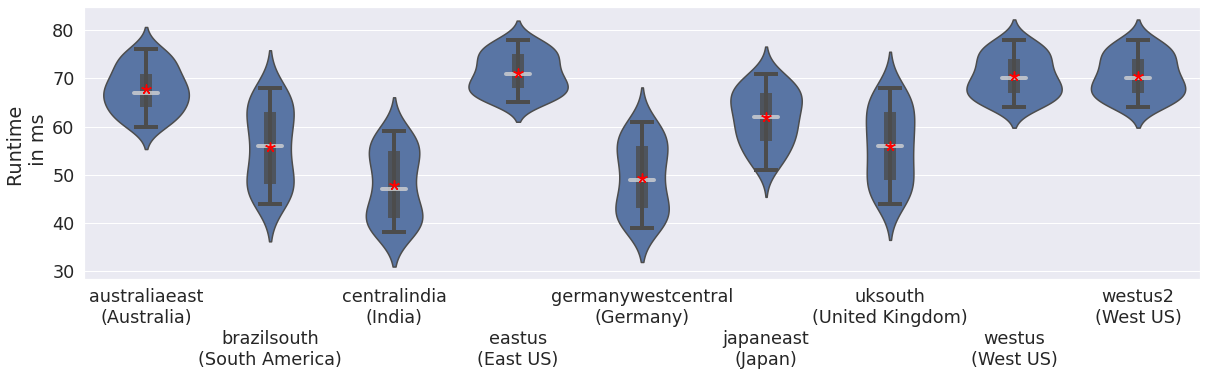

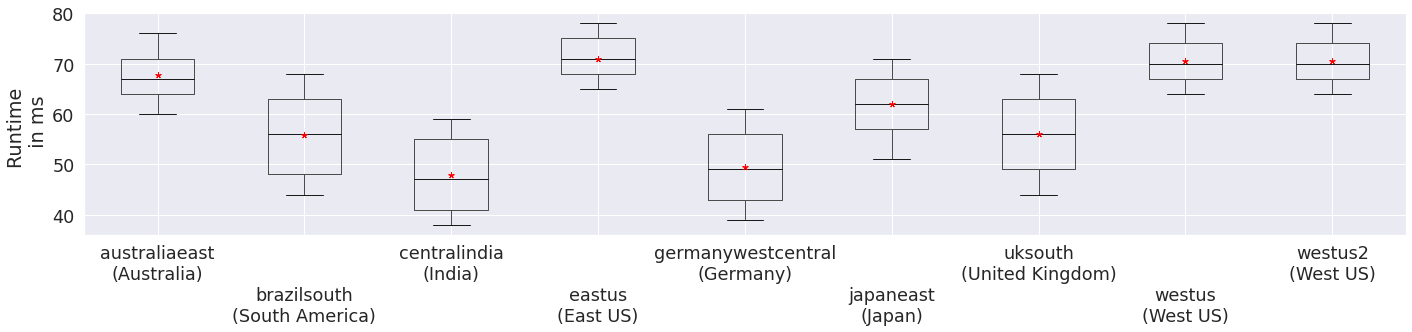

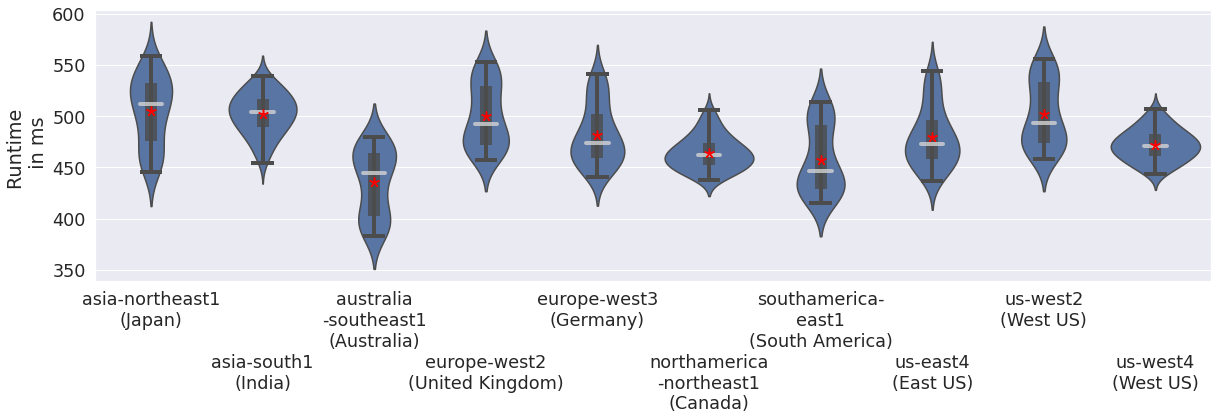

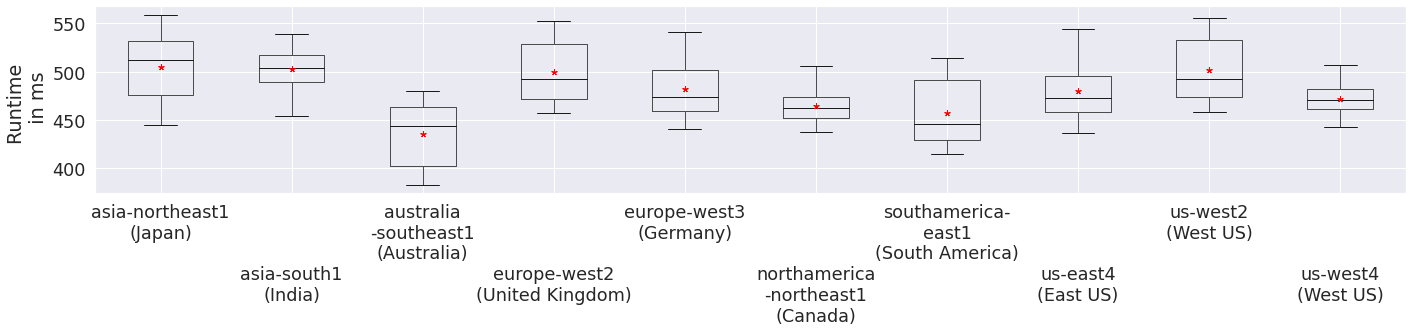

In [12]:
sns.set(font_scale=1.6)

for provider in df['provider'].unique():
    SHAREX = False
    pdf = df[['provider', 'region', 'runtime']][df['provider'] == provider]
    regions = list(pdf['region'].unique())
    no_regions = len(regions)
    fig, axes = plt.subplots(figsize=(20,5)) #, ncols=no_regions, frameon=False, sharex=SHAREX, sharey=True)
    index = 0
    pdf = utils.remove_outliers_group_quantiles(pdf, 'region', 'runtime')
    
    # todo check if ok
    pdf['runtime'] = pdf['runtime'].astype(np.float64)
    pdf['region'] = pdf['region'].cat.remove_unused_categories()
    
    pdf = pdf.sort_values(by=['provider','region'])
    
    ax = violinplotutil.violinplot(x='region', y='runtime', ax=axes, data=pdf, bw=0.5)
    
    axes.set_ylabel('Runtime \n in ms')
    
    utils.savefig(fig, ['region_analysis', f'runtime_violin_provider_{provider}'],
             bxdf=pdf.groupby('region').describe()
                 )
    
    region_name_ax = ax
    labels = []
    i=0
    for tick in region_name_ax.get_xticklabels():
        region = tick.get_text()
        key = f"({provider}, {region})"
        mapping = provider_region_mapping[key]
        region = mapping['region']
        plot_region = mapping['plot region']
        measure_group = mapping['measure group']
        if (i % 2) == 1:
            if provider == 'GCP':
                labels.append(f"\n\n\n{plot_region}\n({measure_group})")
            else:
                labels.append(f"\n\n{plot_region}\n({measure_group})")
        else:
            labels.append(f"{plot_region}\n({measure_group})")
        i+=1
    region_name_ax.set_xticklabels(labels, rotation=0)
    region_name_ax.set_xlabel('')
        
    fig = plt.figure(figsize=(20,5))  #plt.subplots(figsize=(20,5)) #, ncols=no_regions, frameon=False, sharex=SHAREX, sharey=True)
    ax = plt.gca()
    
    bxdf = pdf.groupby(['provider','region'], observed=True)
    
    ax = utils.boxplot(ax, bxdf, "Runtime \n in ms", lambda x: x, rot=0, sharex=False, with_mean=True)
    
    region_name_ax = ax
    labels = []
    i = 0
    for tick in region_name_ax.get_xticklabels():
        region =  tick.get_text().split(',')[1].strip()
        key = f"({provider}, {region})"
        mapping = provider_region_mapping[key]
        region = mapping['region']
        plot_region = mapping['plot region']
        measure_group = mapping['measure group']
        if (i % 2) == 1:
            if provider == 'GCP':
                labels.append(f"\n\n\n{plot_region}\n({measure_group})")
            else:
                labels.append(f"\n\n{plot_region}\n({measure_group})")
        else:
            labels.append(f"{plot_region}\n({measure_group})")
        i+=1

    region_name_ax.set_xticklabels(labels, rotation=0)
    region_name_ax.set_xlabel('')
    
    fig.tight_layout()
    
    utils.savefig(fig, ['region_analysis', f'runtime_boxplot_provider_{provider}'],
             bxdf=bxdf.describe()
                 )

In [13]:
cov_mg_df = df.groupby( ['measure group', 'provider', 'region'], observed=True)['runtime'].apply(utils.cov)
cov_mg_df_percent = cov_mg_df * 100
cov_mg_df_percent

measure group   provider  region                 
Australia       AWS       ap-southeast-2             14.903704
                AZURE     australiaeast              21.522183
                GCP       australia-southeast1       16.488610
Canada          AWS       ca-central-1               16.234144
                GCP       northamerica-northeast1    13.975599
East US         AWS       us-east-1                  14.715527
                AZURE     eastus                     27.718939
                GCP       us-east4                   18.507923
Germany         AWS       eu-central-1               14.282047
                AZURE     germanywestcentral         35.912622
                GCP       europe-west3               18.003871
India           AWS       ap-south-1                 15.594966
                AZURE     centralindia               28.833487
                GCP       asia-south1                15.420295
Japan           AWS       ap-northeast-1             15.985986
     

In [14]:
num_max_regions_group = df.groupby( ['measure group'], observed=True)['region'].nunique().max()
mgs = set(cov_mg_df_percent.index.get_level_values(0))
# mgs_values = {}

mgs_values = {}
for mg in mgs:
    mgs_values[mg] = []

for index, row in cov_mg_df_percent.reset_index().iterrows():
    mg = row['measure group']
    p = row['provider']
    r = row['region']
    runtime = row['runtime']
    mgs_values[mg] = mgs_values[mg] + [{'runtime': runtime, 'provider': p , 'region': r}]
# mgs_values

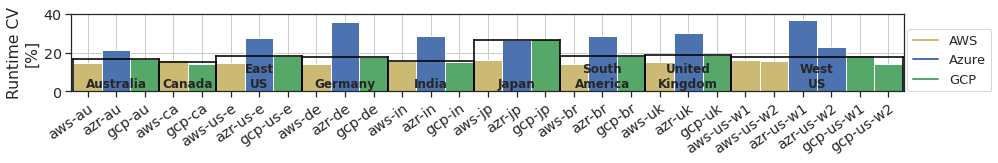

In [90]:
cov_mg_df = cov_mg_df_percent.reset_index().groupby( ['measure group'], observed=True)['runtime'].median()
cov_mg = cov_mg_df.to_dict()
cov_mg
factor=2
sns.set(font_scale=1.3)
sns.set_style("ticks",{'axes.grid' : True})
fig, ax = plt.subplots(figsize=(8.85*2*CM*factor, 2.6*CM*factor))
      
w = 1
x = 0
ticks = []
labels = []
lw=2
for group_idx, mg in enumerate(sorted(mgs)):   
    grp_start = x
    
    for value_idx, values in enumerate(mgs_values[mg]):
        x +=1
        p = values['provider']
        r = values['region']
        c = 'black'
        if values['provider'] == 'AWS':
            c = 'y'
        if values['provider'] == 'AZURE':
            c = 'b'    
        if values['provider'] == 'GCP':
            c = 'g'    
        ax.bar(x, values['runtime'], w, label=(0, 0, p), color = c)
        
        label = region_id_mapping[r]
        ticks.append(x)
        labels.append(label)
        
    grp_end = x
    
    xgs = grp_start + 0.5 * w
    xge = grp_end + 0.5 * w
    gy = cov_mg[mg]
    ax.plot([xgs, xge], [gy, gy], color = 'black', alpha=0.8, linewidth=lw)
    
    # Region
    xgm = (xgs) + (xge - xgs)/2
    
    ax.plot([xgs,  xgs], [gy, 0.1], color = 'black', alpha=0.8, linewidth=lw)
    ax.plot([xge,  xge], [gy, 0.1], color = 'black', alpha=0.8, linewidth=lw)
    ax.annotate(mg.replace(' ', '\n'), (xgm , 2), ha='center', fontsize=12, fontweight='bold')

ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=35, ha="right", rotation_mode="anchor")
ax.margins(x=0)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='y', lw=lw),
                Line2D([0], [0], color='b', lw=lw),
                Line2D([0], [0], color='g', lw=lw)]

pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width, pos.height])
ax.legend(custom_lines, ['AWS', 'Azure', 'GCP'], fontsize='small', loc='center right', bbox_to_anchor=(1.113, 0.4012))

ax.set_xticklabels(labels)



ax.set_xlim(0.43, 29.53)
ax.set_ylim(0, 40)
ax.set_ylabel('Runtime CV\n[%]')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
fig.tight_layout(pad=0)
utils.savefig(fig, ['region_analysis', f'cv_all_regions'], data=cov_df)

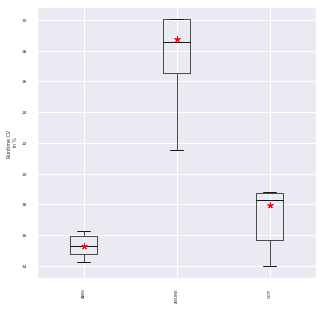

In [16]:
# CV Boxplots
cov_df.groupby('provider')
fig, axes = plt.subplots(figsize=(5,5))

cov_df_percent = cov_df * 100
bxdf = cov_df_percent.reset_index().groupby(['provider'])
axes = utils.boxplot(axes, bxdf, "Runtime CV \n in %", lambda x: x, rot=45, with_mean=True)

labels = []
for tick in axes.get_xticklabels():
    provider =  tick.get_text().split(',')[0].strip()[1:]
    labels.append(provider)
axes.set_xticklabels(labels, rotation=90)

utils.savefig(fig, ['region_analysis', f'cv_boxplot'], data=cov_df)

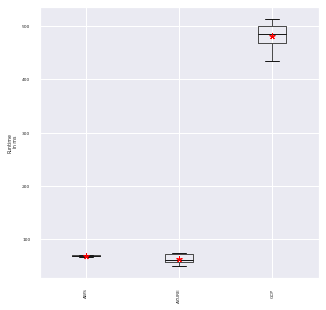

In [17]:
# Runtime Boxplots
mean_region_df = df[['provider', 'region', 'runtime']].groupby(['provider', 'region'], observed=True).mean()
mean_region_df

fig, axes = plt.subplots(figsize=(5,5))
    
bxdf = mean_region_df.groupby('provider')

axes = utils.boxplot(axes, bxdf, "Runtime\n in ms", lambda x: x, rot=45, with_mean=True)

labels = []
for tick in axes.get_xticklabels():
    provider =  tick.get_text().split(',')[0].strip()[1:]
    labels.append(provider)
axes.set_xticklabels(labels, rotation=90)

utils.savefig(fig, ['region_analysis', f'runtime_boxplot'], cvbx=bxdf.describe())

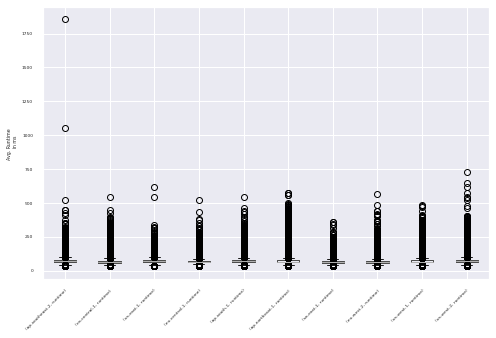

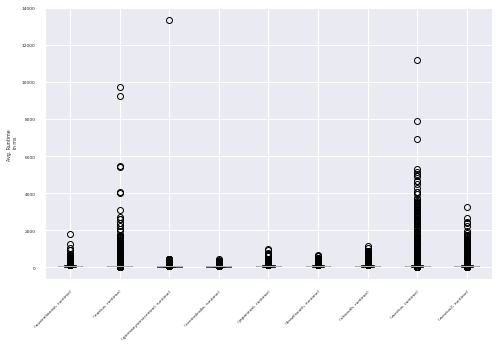

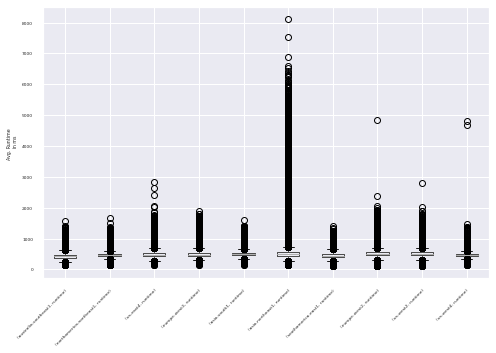

In [18]:
# Mean Runtime with Outliers
for provider in cov_df.index.get_level_values('provider').unique():
    fig, axes = plt.subplots(figsize=(8,5))
    df[['provider', 'region', 'runtime']][df['provider'] == provider].groupby(['region'], observed=True).boxplot(subplots=False, ax=axes, rot=45)
    for tick in axes.get_xticklabels():
        tick.set_rotation(45)
        
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    axes.set_ylabel('Avg. Runtime \n in ms')
    plt.show()
    plt.close()

# CPU Types Analysis
Different Types of CPUs for the different regions.

In [19]:
df = df.sort_values(by=['provider', 'measure group', 'region', 'driver_invocation', 'workload_invocation'])

unique_cpu_types_df = df.groupby(['measure group','provider', 'region', 'cpuType'], observed=True)['cpuType'].count() #.agg({'cpuType':'count'})
unique_cpu_types_df = pd.DataFrame(unique_cpu_types_df).groupby(['provider', 'region'], group_keys=False, observed=True).apply(lambda df: (df['cpuType'] / df['cpuType'].sum()) * 100)
unique_cpu_types_percentage_df = pd.DataFrame(unique_cpu_types_df)
unique_cpu_types_percentage_df = unique_cpu_types_percentage_df.rename(columns={'cpuType': 'Percentage'})
unique_cpu_types_percentage_df = unique_cpu_types_percentage_df.reset_index('cpuType')
unique_cpu_types_pivoted_df = unique_cpu_types_percentage_df.pivot(columns=['cpuType'])
unique_cpu_types_pivoted_df

Percentage  \
cpuType                                         Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz - Model 63   
measure group  provider region                                                                         
Australia      AWS      ap-southeast-2                                                         NaN     
               AZURE    australiaeast                                                    16.797081     
               GCP      australia-southeast1                                                   NaN     
Canada         AWS      ca-central-1                                                           NaN     
               GCP      northamerica-northeast1                                                NaN     
East US        AWS      us-east-1                                                              NaN     
               AZURE    eastus                                                           24.544859     
               GCP      us-east4                                                               NaN     
Germany        AWS      eu-central-1                                                           NaN     
               AZURE    germanywestcentral                                                     NaN     
               GCP      europe-west3                                                           NaN     
India          AWS      ap-south-1                                                             NaN     
               AZURE    centralindia                                                      0.309975     
               GCP      asia-south1                                                            NaN     
Japan          AWS      ap-northeast-1                                                         NaN     
               AZURE    japaneast                                                         0.076161     
               GCP      asia-northeast1                                                        NaN     
South America  AWS      sa-east-1                                                              NaN     
               AZURE    brazilsouth                                                      26.982614     
               GCP      southamerica-east1                                                     NaN     
United Kingdom AWS      eu-west-2                                                              NaN     
               AZURE    uksouth                                                          10.108581     
               GCP      europe-west2                                                           NaN     
West US        AWS      us-west-1                                                              NaN     
                        us-west-2                                                              NaN     
               AZURE    westus                                                           16.786612     
                        westus2                                                           1.140948     
               GCP      us-west2                                                               NaN     
                        us-west4                                                               NaN     

                                                                                                      \
cpuType                                         Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - Model 79   
measure group  provider region                                                                         
Australia      AWS      ap-southeast-2                                                         NaN     
               AZURE    australiaeast                                                    57.619793     
               GCP      australia-southeast1                                                   NaN     
Canada         AWS      ca-central-1                                                           NaN     
               GCP      northamer

In [20]:
unique_cpu_types_pivoted_df

Percentage  \
cpuType                                         Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz - Model 63   
measure group  provider region                                                                         
Australia      AWS      ap-southeast-2                                                         NaN     
               AZURE    australiaeast                                                    16.797081     
               GCP      australia-southeast1                                                   NaN     
Canada         AWS      ca-central-1                                                           NaN     
               GCP      northamerica-northeast1                                                NaN     
East US        AWS      us-east-1                                                              NaN     
               AZURE    eastus                                                           24.544859     
               GCP      us-east4                                                               NaN     
Germany        AWS      eu-central-1                                                           NaN     
               AZURE    germanywestcentral                                                     NaN     
               GCP      europe-west3                                                           NaN     
India          AWS      ap-south-1                                                             NaN     
               AZURE    centralindia                                                      0.309975     
               GCP      asia-south1                                                            NaN     
Japan          AWS      ap-northeast-1                                                         NaN     
               AZURE    japaneast                                                         0.076161     
               GCP      asia-northeast1                                                        NaN     
South America  AWS      sa-east-1                                                              NaN     
               AZURE    brazilsouth                                                      26.982614     
               GCP      southamerica-east1                                                     NaN     
United Kingdom AWS      eu-west-2                                                              NaN     
               AZURE    uksouth                                                          10.108581     
               GCP      europe-west2                                                           NaN     
West US        AWS      us-west-1                                                              NaN     
                        us-west-2                                                              NaN     
               AZURE    westus                                                           16.786612     
                        westus2                                                           1.140948     
               GCP      us-west2                                                               NaN     
                        us-west4                                                               NaN     

                                                                                                      \
cpuType                                         Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - Model 79   
measure group  provider region                                                                         
Australia      AWS      ap-southeast-2                                                         NaN     
               AZURE    australiaeast                                                    57.619793     
               GCP      australia-southeast1                                                   NaN     
Canada         AWS      ca-central-1                                                           NaN     
               GCP      northamer

In [21]:
cpu_map = {
    "Intel(R) Xeon(R) Processor @ 2.50GHz - Model 63": "Xeon\n@2.50GHz\n (Model 63)",
    "Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz - Model 85": "Xeon\nPlatinum\n8171M\n@2.60GHz\n(Model 85)",
    "Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - Model 79": "Xeon\nE5-2673 v4\n@2.30GHz\n(Model 79)",
    "Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz - Model 85": "Xeon\nPlatinum\n8272CL\n@2.60GHz\n(Model 85)",
    "Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz - Model 63": "Xeon\nE5-2673 v3\n@2.40GHz\n(Model 63)",
    "Intel(R) Xeon(R) Processor @ 3.00GHz - Model 63": "Xeon\n@3.00GHz\n(Model 63)",
    "unknown - Model 63": "Model 63",
    "unknown - Model 85": "Model 85",
    "unknown - Model 79": "Model 79"
}

In [91]:
cpu_map = {
    "Intel(R) Xeon(R) Processor @ 2.50GHz - Model 63": "Model 63A",
    "Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz - Model 85": "Model 85M",
    "Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - Model 79": "Model 79",
    "Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz - Model 85": "Model 85CL",
    "Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz - Model 63": "Model 63",
    "Intel(R) Xeon(R) Processor @ 3.00GHz - Model 63": "Model 63B",
    "unknown - Model 63": "Model 63",
    "unknown - Model 85": "Model 85",
    "unknown - Model 79": "Model 79"
}

In [1]:
sns.set(font_scale=1.4)
sns.set_style("ticks",{'axes.grid' : True})
for provider in df['provider'].unique():
    fig, axes = plt.subplots(figsize=(8.85*CM*factor, 3.2*CM*factor))
    factor=2
    subdf = unique_cpu_types_pivoted_df
    providerdf = subdf[subdf.index.isin([provider], level=1)]

    cols = providerdf.columns.droplevel(0)
    new_cols = [cpu_map[x] for x in cols]
    providerdf.columns = new_cols
    providerdf = providerdf.dropna(axis=1, how='all')
    providerdf = providerdf.sort_values(by=['provider', 'region'])
    providerdf.plot.bar(stacked=True, ax=axes, rot=0)
    
    # Put Legend To Outside
    box = axes.get_position()
    axes.set_position([box.x0, box.y0, box.width * 0.9, box.height])
    axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Reverse labels fix
    handles, labels = axes.get_legend_handles_labels()
    axes.legend(handles[::-1], labels[::-1], title='', loc='center left', bbox_to_anchor=(0.985, 0.5))

    axes.set_xlabel('')
    axes.set_ylabel('Percentage (%)')
    
    # Set Region Names
    labels = []
    i = 0
    for tick in axes.get_xticklabels():
        region = tick.get_text()
        region =  tick.get_text().split(',')[2].strip()[:-1]
        key = f"({provider}, {region})"
        mapping = provider_region_mapping[key]
        region = mapping['region']
        measure_group = mapping['measure group']
        label = region_id_mapping[region]
        labels.append(label)
        #labels.append(f"{region}\n({measure_group})")
        
        i+=1
        
    axes.set_xticklabels(labels)
    axes.set_xticklabels(axes.get_xticklabels(), rotation=25, ha="right", rotation_mode="anchor")
    fig.tight_layout(pad=0)
    utils.plot( ['region_analysis', f'cpu_types_{provider}'], cpu_types_percentrage=providerdf)

NameError: name 'sns' is not defined

In [24]:
cputype_per_invocation_df = pd.DataFrame(df.groupby(['provider', 'region', 'driver_invocation'], observed=True)['cpuType'].nunique().rename('Count'))

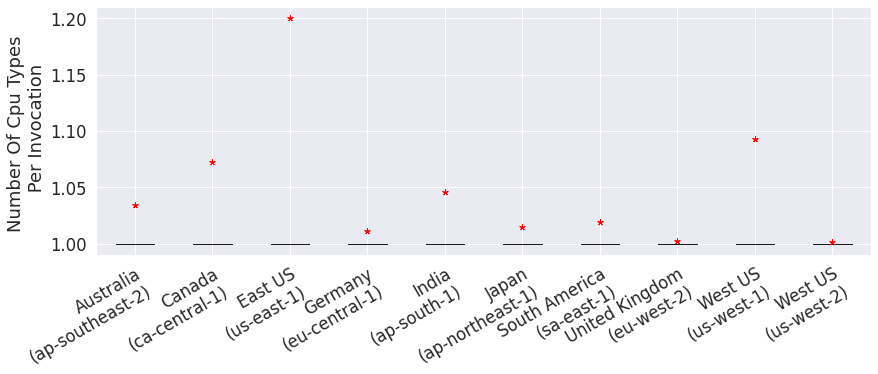

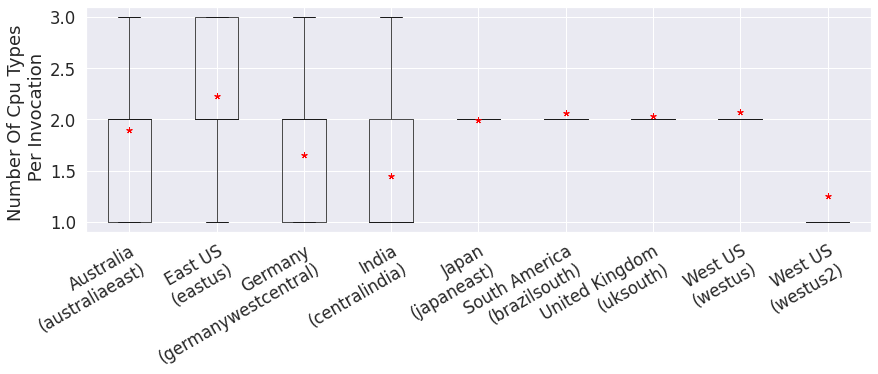

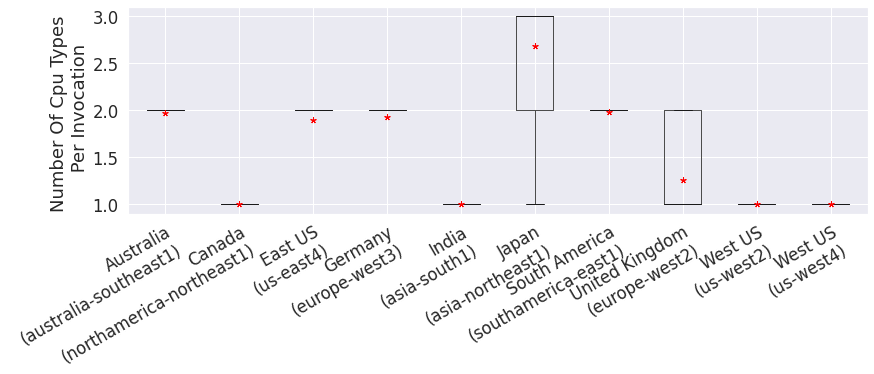

In [25]:
sns.set(font_scale=1.5)
for provider in df['provider'].unique():
    fig, axes = plt.subplots(figsize=(12,5))
    subdf = cputype_per_invocation_df
    provdf = subdf.loc[provider]
    provdfgrp = provdf.groupby('region')
    #provdf.boxplot(by='region', rot=45, ax=axes)
    
    axes = utils.boxplot(axes, provdfgrp, "Runtime\n in ms", lambda x: x, rot=0, with_mean=True)
    
    # Set Region Names
    labels = []
    i = 0
    for tick in axes.get_xticklabels():
        region =  tick.get_text().split(',')[0].strip().strip('(')
        key = f"({provider}, {region})"
        mapping = provider_region_mapping[key]
        region = mapping['region']
        measure_group = mapping['measure group']
        labels.append(f"{measure_group}\n({region})")
        i+=1
    axes.set_xticklabels(labels)
    
    # Other Formatting
    axes.set_title('')
    fig.suptitle('')
    axes.set_xlabel('')
    axes.set_ylabel('Number Of Cpu Types \n Per Invocation')
    
    axes.set_xticklabels(axes.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")
    
    fig.tight_layout(pad=0)
    utils.savefig(fig, ['region_analysis', f'invocation_cpu_types_{provider}'], cputype_per_invocation_df=provdf.groupby('region').describe())
    # utils.plot( ['region_analysis', f'invocation_cpu_types_{provider}'], cputype_per_invocation_df=provdf.groupby('region').describe())